In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.signal
import cartopy.crs as ccrs
import sys
sys.path.append('/Volumes/KT-TOSHIBA/ENOI/CODE')
import regression_fcts as rf
import enoi_functions as enoi

In [2]:
from dask.distributed import Client
client = Client('tcp://127.0.0.1:8786')

In [3]:
mdata = '/Volumes/KT-TOSHIBA/ENOI/sorted_model_data/'

years_used = -60
mdict = {'lat':'lat', 'lon':'lon', 'lev':'lev', 'lev_bnds':'lev_bnds'}
limit_z = 2000
lon = np.arange(0.5,360.5)
lat = np.arange(-89.5,90.5)

m0 = xr.open_dataset('/Volumes/KT-TOSHIBA/ENOI/CMIP6/forcings/mol1.nc', decode_times=False)
pco2 = m0.mole_fraction_of_carbon_dioxide_in_air[years_used:,0]
pco2_anom = pco2 - np.nanmean(pco2)
pco2_extended = np.tile(pco2.data - np.nanmean(pco2.data), 
                        int(1800/np.abs(years_used)))

argo_coverage= xr.open_dataset('/Volumes/KT-TOSHIBA/ENOI/CODE/argo_mask.nc')
argo_mask = argo_coverage.argo_annualcoverage

f_theta = xr.open_dataset('/Volumes/KT-TOSHIBA/ENOI/CMIP6/regrid_horiz/thetao_Oyr_NorESM2-LM_historical_r1i1p1f1_gr_1950-2014_1x1r.nc')
f_so = xr.open_dataset('/Volumes/KT-TOSHIBA/ENOI/CMIP6/regrid_horiz/so_Oyr_NorESM2-LM_historical_r1i1p1f1_gr_1950-2014_1x1r.nc')

In [44]:
molC2gC = 12.011

In [23]:
Nor_recon = np.zeros(shape=(14,4,180,360))

ul=[0, 100, 500, 1000]
ll=[100, 500, 1000, 2000]
radii=[5,2,1,0]
#radii=[0,0,0,0]

In [24]:
for i in np.arange(4):
    r = radii[i]

    dissic_SORTED, thetao_SORTED, so_SORTED, emask, lmask = enoi.load_data_depths(ul[i],ll[i])

    ### Load in NorESM data and drift data for this depth level

    if i==0:
        nor_theta = rf.integ_layer(f_theta, f_theta.thetao, 100, years_used, mdict)[0]
        nor_so = rf.integ_layer(f_so, f_so.so, 100, years_used, mdict)[0]
        
        drift_dissic = np.load("drift_ts_dissic0100.npy")
        drift_thetao = np.load("drift_ts_thetao0100.npy")
        drift_so = np.load("drift_ts_so0100.npy")
        
        drift_thetao_nor = np.load("drift_nor_thetao0100.npy")
        drift_so_nor = np.load("drift_nor_so0100.npy")
    
        nor_theta = nor_theta - np.nanmean(nor_theta, axis=0) - drift_thetao_nor
        nor_so = nor_so - np.nanmean(nor_so, axis=0) - drift_so_nor
    else:
        nor_theta1 = rf.integ_layer(f_theta, f_theta.thetao, ul[i], years_used, mdict)[0]
        nor_theta2 = rf.integ_layer(f_theta, f_theta.thetao, ll[i], years_used, mdict)[0]
        nor_so1 = rf.integ_layer(f_so, f_so.so, ul[i], years_used, mdict)[0]
        nor_so2 = rf.integ_layer(f_so, f_so.so, ll[i], years_used, mdict)[0]
        
        nor_drift_thetao_ul = np.load(f"drift_nor_thetao{ul[i]:04d}.npy")
        nor_drift_so_ul = np.load(f"drift_nor_so{ul[i]:04d}.npy")
        nor_drift_thetao_ll = np.load(f"drift_nor_thetao{ll[i]:04d}.npy")
        nor_drift_so_ll = np.load(f"drift_nor_so{ll[i]:04d}.npy")
        
        drift_dissic_ul = np.load(f"drift_ts_dissic{ul[i]:04d}.npy")
        drift_dissic_ll = np.load(f"drift_ts_dissic{ll[i]:04d}.npy")
        drift_thetao_ul = np.load(f"drift_ts_thetao{ul[i]:04d}.npy")
        drift_thetao_ll = np.load(f"drift_ts_thetao{ll[i]:04d}.npy")
        drift_so_ul = np.load(f"drift_ts_so{ul[i]:04d}.npy")
        drift_so_ll = np.load(f"drift_ts_so{ll[i]:04d}.npy")
        
        drift_dissic = drift_dissic_ll - drift_dissic_ul
        drift_thetao = drift_thetao_ll - drift_thetao_ul
        drift_so = drift_so_ll - drift_so_ul
        
        drift_thetao_nor = nor_drift_thetao_ll - nor_drift_thetao_ul
        drift_so_nor = nor_drift_so_ll - nor_drift_so_ul
    
        nor_theta = nor_theta2 - nor_theta1 - np.nanmean(nor_theta2 - nor_theta1, axis=0) - drift_thetao_nor
        nor_so = nor_so2 - nor_so1 - np.nanmean(nor_so2 - nor_so1, axis=0) - drift_so_nor
    
    emask[nor_theta[0,:,:]==0] = 0
    
    dissic = dissic_SORTED - drift_dissic
    thetao = thetao_SORTED - drift_thetao
    so = so_SORTED - drift_so

    ###############################################################################
    ## construct weights and create NorESM reconstruction for each point at a certain depth level
    
    for lat_i in np.arange(len(lat)-r):
        for lon_i in np.arange(r,len(lon)-r):

            data_test = emask[lat_i,lon_i]#check to make sure there is ensemble AND NorESM DIC data at this location
        
            if data_test == 1:
                dic_loc = dissic[:,lat_i,lon_i]
            
                argo_pCO2 = np.zeros(14)
                argo_Tweight = np.zeros(shape=(14,2*r+1,2*r+1))
                argo_Sweight = np.zeros(shape=(14,2*r+1,2*r+1))
            
                for yr in np.arange(14):
                
                    if lon_i < r:
                        argo_test = np.hstack([argo_mask[yr,lat_i-r:lat_i+r+1, lon_i-r:-1], 
                                              argo_mask[yr,lat_i-r:lat_i+r+1, 0:lon_i+r+1]])
                        argo_idx1 = np.where(argo_mask[yr,lat_i-r:lat_i+r+1, lon_i-r:-1] == 1)
                        argo_idx2 = np.where(argo_mask[yr,lat_i-r:lat_i+r+1, 0:lon_i+r+1] == 1)
                        argo_idx = [np.hstack([argo_idx1[0],argo_idx2[0]]), 
                                    np.hstack([argo_idx1[1],argo_idx2[1]+r-lon_i-1])]
                    elif lon_i > (lon[-1]-r) :
                        argo_test = np.hstack(argo_mask[yr,lat_i-r:lat_i+r+1, lon_i-r:-1], 
                                              argo_mask[yr,lat_i-r:lat_i+r+1, 0:np.mod(lon_i+r+1,360)])
                    else:
                        argo_test = argo_mask[yr,lat_i-r:lat_i+r+1,lon_i-r:lon_i+r+1].data
                        argo_idx = np.where(argo_mask[yr,lat_i-r:lat_i+r+1,lon_i-r:lon_i+r+1] == 1)
                
                    if argo_test.sum() > 0:
                    
                        nprof = argo_test.sum().astype('int')
                        #concatinate temperature and salinity profile locations for solver
                        temp_subsamp = thetao[:,lat_i-r:lat_i+r+1,lon_i-r:lon_i+r+1]
                        sal_subsamp = so[:,lat_i-r:lat_i+r+1,lon_i-r:lon_i+r+1]
                    
                        temp_prof = np.zeros(shape=(1800,nprof))
                        sal_prof = np.zeros(shape=(1800,nprof))
                    
                        for ii in np.arange(nprof):
                            temp_prof[:,ii] = temp_subsamp[:,argo_idx[0][ii], argo_idx[1][ii]]
                            sal_prof[:,ii] = sal_subsamp[:,argo_idx[0][ii], argo_idx[1][ii]]
                        
                        input_vars = np.concatenate((temp_prof,sal_prof,np.expand_dims(pco2_extended,1)),axis=1)
                    
                        dummy = scipy.linalg.lstsq(input_vars, dic_loc)
                        argo_pCO2[yr] = dummy[0][-1] 
                        for ii in np.arange(nprof):
                            argo_Tweight[yr,argo_idx[0][ii], argo_idx[1][ii]] = dummy[0][ii]
                            argo_Sweight[yr,argo_idx[0][ii], argo_idx[1][ii]] = dummy[0][nprof+ii]
                    else:
                        input_vars = np.expand_dims(pco2_extended,1)
                        dummy = scipy.linalg.lstsq(input_vars, dic_loc)
                        argo_pCO2[yr] = dummy[0][0]
                        argo_Tweight[yr,:,:] = 0
                        argo_Sweight[yr,:,:] = 0
                    
                #now create reconstructed NorESM
                nor_subsamp_temp = nor_theta[-14:,lat_i-r:lat_i+r+1,lon_i-r:lon_i+r+1]
                nor_subsamp_sal = nor_so[-14:,lat_i-r:lat_i+r+1,lon_i-r:lon_i+r+1]
            
                Nor_recon[:,i,lat_i,lon_i] = (argo_pCO2 * pco2_extended[-14:] 
                                          + np.nansum(argo_Tweight * nor_subsamp_temp, axis=(1,2)) 
                                          + np.nansum(argo_Sweight * nor_subsamp_sal, axis=(1,2)))

np.save("nor_recon.npy", Nor_recon)

/Volumes/KT-TOSHIBA/ENOI/CODE/enoi_functions.py:94: RuntimeWarning: invalid value encountered in divide
  test1 = np.isnan(np.mean(input_file/input_file, axis=0)) # find where model ensemble doesnt always have data
/Volumes/KT-TOSHIBA/ENOI/CODE/enoi_functions.py:94: RuntimeWarning: invalid value encountered in divide
  test1 = np.isnan(np.mean(input_file/input_file, axis=0)) # find where model ensemble doesnt always have data
/Volumes/KT-TOSHIBA/ENOI/CODE/enoi_functions.py:94: RuntimeWarning: invalid value encountered in divide
  test1 = np.isnan(np.mean(input_file/input_file, axis=0)) # find where model ensemble doesnt always have data
/Volumes/KT-TOSHIBA/ENOI/CODE/enoi_functions.py:94: RuntimeWarning: invalid value encountered in divide
  test1 = np.isnan(np.mean(input_file/input_file, axis=0)) # find where model ensemble doesnt always have data


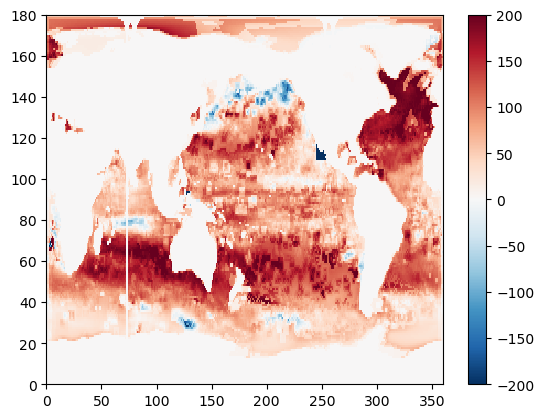

In [29]:
plt.pcolormesh(12.011*np.sum(Nor_recon[-1,:,:,:] - Nor_recon[0,:,:,:], axis=0), 
               vmin=-200, vmax=200, cmap=plt.get_cmap("RdBu_r"))
plt.colorbar()

In [52]:
f_dic = xr.open_dataset('/Volumes/KT-TOSHIBA/ENOI/CMIP6/regrid_horiz/dissic_Oyr_NorESM2-LM_historical_r1i1p1f1_gr_1950-2014_1x1r.nc')
nor_dic1 = rf.integ_layer(f_dic, f_dic.dissic, 100, years_used, mdict)[0]
nor_dic2 = rf.integ_layer(f_dic, f_dic.dissic, 500, years_used, mdict)[0]
nor_dic3 = rf.integ_layer(f_dic, f_dic.dissic, 1000, years_used, mdict)[0]
nor_dic4 = rf.integ_layer(f_dic, f_dic.dissic, 2000, years_used, mdict)[0]

In [37]:
area_f = xr.open_dataset('/Volumes/KT-TOSHIBA/ENOI/CMIP6/mCESM2/areacello_Ofx_CESM2_historical_r1i1p1f1_gr.nc')
area = area_f.areacello
area2 = np.tile(area, [60,1,1])

In [32]:
drift_nor_dissic100 = np.load("drift_nor_dissic0100.npy")
drift_nor_dissic500 = np.load("drift_nor_dissic0500.npy")
drift_nor_dissic1000 = np.load("drift_nor_dissic1000.npy") 
drift_nor_dissic2000 = np.load("drift_nor_dissic2000.npy")

In [69]:
nor_dic_0_100 = nor_dic1 - drift_nor_dissic100
nor_dic_100_500 = nor_dic2 - nor_dic1 - (drift_nor_dissic500 - drift_nor_dissic100)
nor_dic_500_1000 = nor_dic3 - nor_dic2 - (drift_nor_dissic1000 - drift_nor_dissic500)
nor_dic_1000_2000 = nor_dic4 - nor_dic3 - (drift_nor_dissic2000 - drift_nor_dissic1000)

In [89]:
nor_dic01_r = nor_dic_0_100 - np.nanmean(nor_dic_0_100, axis=0)
nor_dic05_r = nor_dic_100_500 - np.nanmean(nor_dic_100_500, axis=0)
nor_dic10_r = nor_dic_500_1000 - np.nanmean(nor_dic_500_1000, axis=0)
nor_dic20_r = nor_dic_1000_2000 - np.nanmean(nor_dic_1000_2000, axis=0)

nor_dic_full2k = nor_dic01_r + nor_dic05_r + nor_dic10_r + nor_dic20_r

In [79]:
recon_dic_full = np.cumsum(Nor_recon, axis=1)

years_full = np.arange(1955, 2015)
years_argo = np.arange(2015-14, 2015)

#now integrate by area and add up for global figures
nor_global_01 = np.nansum(nor_dic01_r*area2, axis=(1,2)) 
nor_global_05 = np.nansum(nor_dic05_r*area2, axis=(1,2)) 
nor_global_10 = np.nansum(nor_dic10_r*area2, axis=(1,2)) 
nor_global_20 = np.nansum(nor_dic20_r*area2, axis=(1,2)) 

recon_global_01 = np.nansum(Nor_recon[:,0,:,:]*area2[-14:,:,:], axis=(1,2))
recon_global_05 = np.nansum(Nor_recon[:,1,:,:]*area2[-14:,:,:], axis=(1,2))
recon_global_10 = np.nansum(Nor_recon[:,2,:,:]*area2[-14:,:,:], axis=(1,2))
recon_global_20 = np.nansum(Nor_recon[:,3,:,:]*area2[-14:,:,:], axis=(1,2))

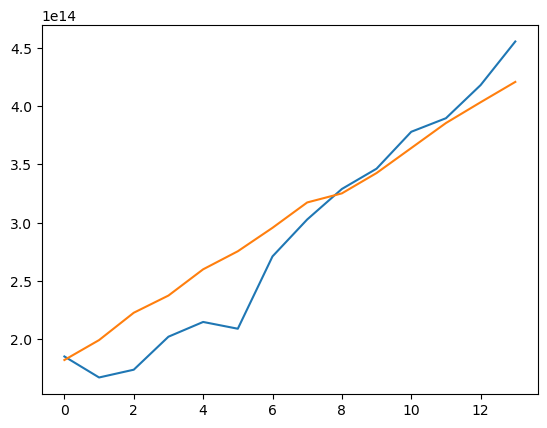

In [81]:
plt.plot(nor_global_20[-14:])
plt.plot(recon_global_20[-14:])

In [91]:
dec_truth = (np.nanmean(nor_dic_full2k[-5:,:,:], axis =0) - 
          np.nanmean(nor_dic_full2k[-14:-14+5,:,:], axis=0))
dec_recon = (np.nanmean(recon_dic_full[-5:,-1,:,:], axis =0) - 
          np.nanmean(recon_dic_full[-14:-14+5,-1,:,:], axis=0))

In [42]:
############### FIGURE HERE ##################
ens_mask = np.load(f'{mdata}mask_2000.npy')
i_2k, l_2k = enoi.create_mask(Nor_recon[:,-1,:,:], f'{mdata}mask_2000.npy')


inann1 = enoi.sew_seams(recon_dic_full[-1,-1,:,:] - recon_dic_full[-2,-1,:,:], ens_mask)
inann2 = np.ma.masked_where(l_2k, inann1)
dec1 = enoi.sew_seams(dec_recon, ens_mask)
dec2 = np.ma.masked_where(l_2k,dec1)
###############################################################################

/Volumes/KT-TOSHIBA/ENOI/CODE/enoi_functions.py:94: RuntimeWarning: invalid value encountered in divide
  test1 = np.isnan(np.mean(input_file/input_file, axis=0)) # find where model ensemble doesnt always have data


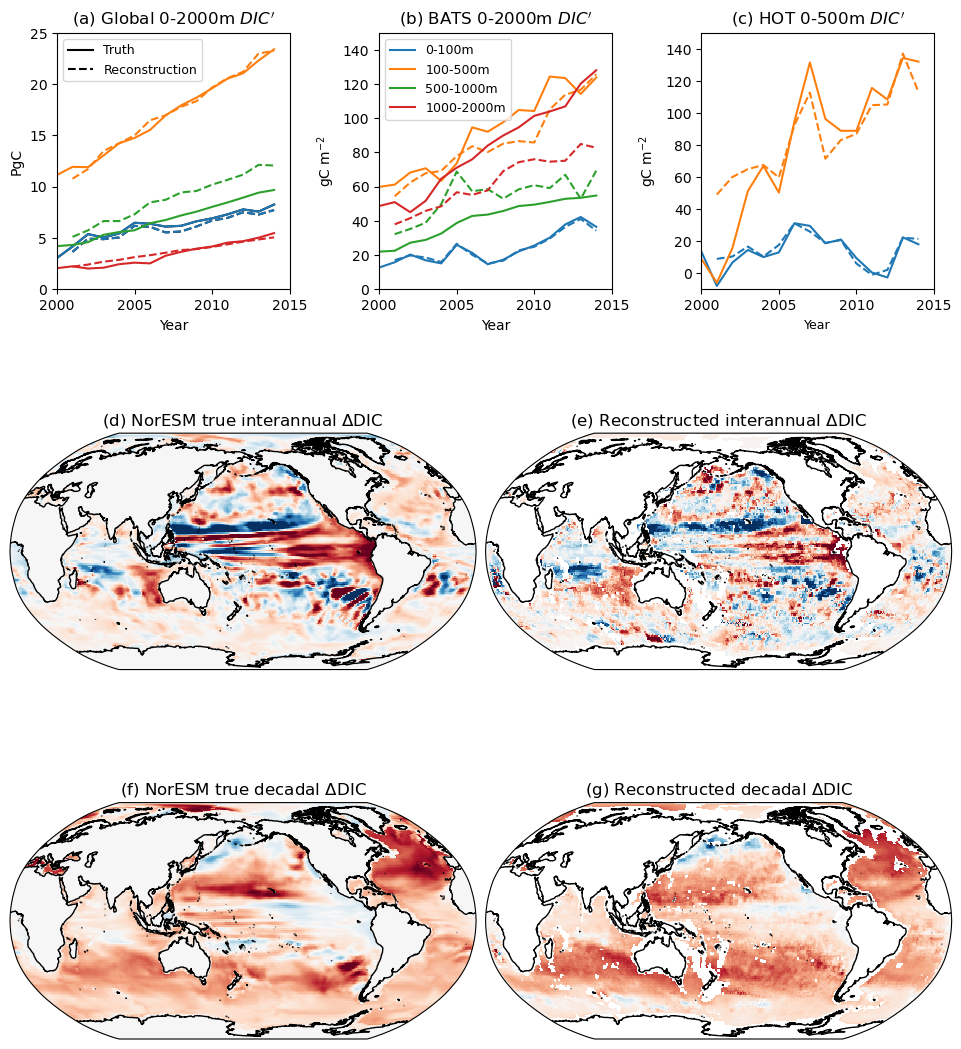

In [106]:
fig, ax = plt.subplots(figsize=(9.5,11), layout="constrained")
ax_glob = plt.subplot(4,3,1)
ax_glob.plot(years_full, nor_global_01* molC2gC*1e-15, 'k', label='Truth')
ax_glob.plot(years_argo, recon_global_01* molC2gC*1e-15, 'k--', 
             label='Reconstruction')
ax_glob.plot(years_full, nor_global_01* molC2gC*1e-15)
ax_glob.plot(years_argo, recon_global_01* molC2gC*1e-15, '--', color= 'tab:blue')
ax_glob.plot(years_full, nor_global_05* molC2gC*1e-15)
ax_glob.plot(years_argo, recon_global_05* molC2gC*1e-15, '--', 
             color='tab:orange')
ax_glob.plot(years_full, nor_global_10* molC2gC*1e-15)
ax_glob.plot(years_argo, recon_global_10* molC2gC*1e-15, '--',
             color='tab:green')
ax_glob.plot(years_full, nor_global_20* molC2gC*1e-15)
ax_glob.plot(years_argo, recon_global_20* molC2gC*1e-15, '--',
             color='tab:red')
plt.legend(fontsize=9)
ax_glob.set_xlim([2000, 2015])
ax_glob.set_ylim([0, 25])
ax_glob.set_ylabel('PgC')
ax_glob.set_xlabel('Year')
ax_glob.set_title("(a) Global 0-2000m $DIC'$")

ax_BATS = plt.subplot(4,3,2)
ax_BATS.plot(years_full, nor_dic01_r[:,121,295]* molC2gC, label='0-100m')
ax_BATS.plot(years_argo, Nor_recon[:,0,121,295]* molC2gC, '--', color='tab:blue')
ax_BATS.plot(years_full, nor_dic05_r[:,121,295]* molC2gC,
             label='100-500m')
ax_BATS.plot(years_argo, Nor_recon[:,1,121,295]* molC2gC, 
             '--', color='tab:orange')
ax_BATS.plot(years_full, nor_dic10_r[:,121,295]* molC2gC,
             label='500-1000m')
ax_BATS.plot(years_argo, Nor_recon[:,2,121,295]* molC2gC, 
             '--', color='tab:green')
ax_BATS.plot(years_full, nor_dic20_r[:,121,295]* molC2gC,
             label='1000-2000m')
ax_BATS.plot(years_argo, Nor_recon[:,3,121,295]* molC2gC, 
             '--', color='tab:red')
ax_BATS.legend(fontsize=9)
ax_BATS.set_xlim([2000, 2015])
ax_BATS.set_ylim([0, 150])
ax_BATS.set_xlabel('Year')
ax_BATS.set_ylabel("gC m$^{-2}$")
ax_BATS.set_title("(b) BATS 0-2000m $DIC'$")

ax_HOT = plt.subplot(4,3,3)
ax_HOT.plot(years_full, nor_dic01_r[:,112,201]* molC2gC, label='0-100m')
ax_HOT.plot(years_argo, Nor_recon[:,0,112,201]* molC2gC, '--', color='tab:blue')
ax_HOT.plot(years_full, nor_dic05_r[:,112,201]* molC2gC,
             label='100-500m')
ax_HOT.plot(years_argo, Nor_recon[:,1,112,201]* molC2gC, 
             '--', color='tab:orange')
ax_HOT.set_xlim([2000, 2015])
ax_HOT.set_ylim([-10, 150])
ax_HOT.set_ylabel('gC m$^{-2}$')
ax_HOT.set_xlabel('Year', fontsize=9)
ax_HOT.set_title("(c) HOT 0-500m $DIC'$")

ax0 = plt.subplot(3, 2, 3, projection=ccrs.Robinson(central_longitude=180))
ax0.coastlines('50m')
p0 = ax0.pcolormesh(lon, lat, (nor_dic_full2k[-1,:,:] - nor_dic_full2k[-2,:,:])* molC2gC,
                     transform=ccrs.PlateCarree(central_longitude=0, globe=None),
                     vmin=-100, vmax=100,cmap=plt.get_cmap('RdBu_r'))
#plt.colorbar(p0,ax=ax0)
ax0.set_title('(d) NorESM true interannual $\Delta$DIC')

ax1 = plt.subplot(3, 2, 4, projection=ccrs.Robinson(central_longitude=180))
ax1.coastlines('50m')
ax1.pcolormesh(lon, lat, inann2 * molC2gC, transform=ccrs.PlateCarree(central_longitude=0, globe=None), 
               vmin=-100, vmax=100,cmap=plt.get_cmap('RdBu_r'))
ax1.set_title('(e) Reconstructed interannual $\Delta$DIC')


ax3 = plt.subplot(3,2,5, projection=ccrs.Robinson(central_longitude=180))
ax3.coastlines('50m')
p3 = plt.pcolormesh(lon, lat, dec_truth*molC2gC, vmin=-200, vmax=200, cmap=plt.get_cmap('RdBu_r'),
               transform=ccrs.PlateCarree(central_longitude=0, globe=None))
#plt.colorbar(p3,ax=ax3)
ax3.set_title('(f) NorESM true decadal $\Delta$DIC')

ax4 = plt.subplot(3,2,6, projection=ccrs.Robinson(central_longitude=180))
ax4.coastlines('50m')
plt.pcolormesh(lon, lat, dec2*molC2gC, vmin=-200, vmax=200, cmap=plt.get_cmap('RdBu_r'),
               transform=ccrs.PlateCarree(central_longitude=0, globe=None))
ax4.set_title('(g) Reconstructed decadal $\Delta$DIC')

plt.savefig('pc_manuscript_figures/recon_NorESM.png', format='png', dpi=150)
###############################################################################

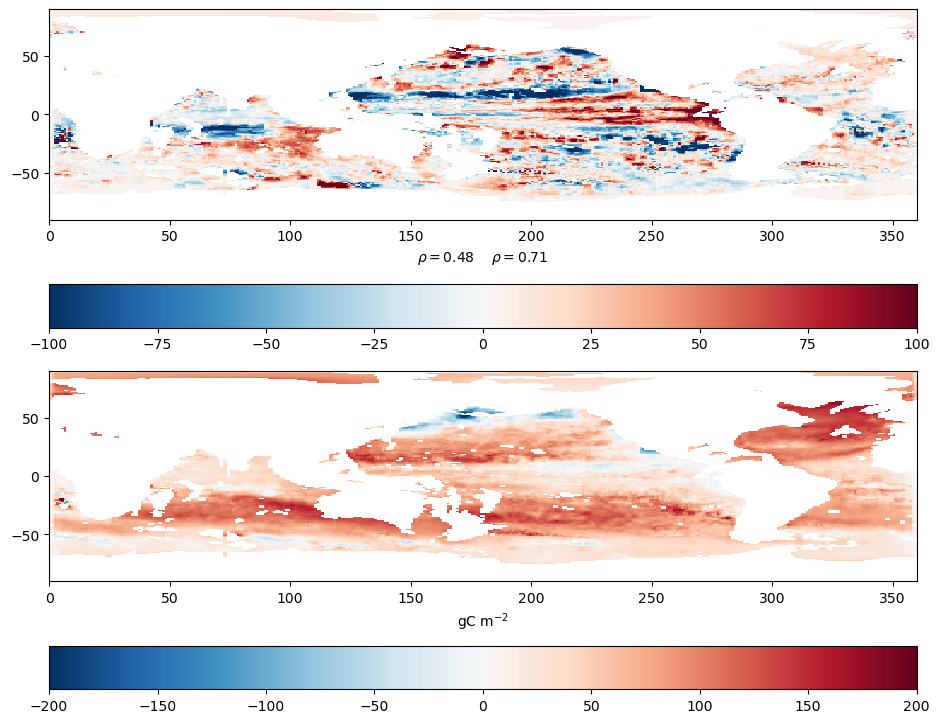

In [108]:
### This is for making the colorbars so that I can paste them into the original
### figure -- wish my python skills were better, alas...
plt.figure(figsize=(9.5,11))

ax1 = plt.subplot(3,1,2)
p0 = ax1.pcolormesh(lon, lat, inann2 * molC2gC, vmin=-100, vmax=100,cmap=plt.get_cmap('RdBu_r'))
ax1.set_xlabel(r'$\rho = 0.48$    $\rho = 0.71$')
plt.colorbar(p0, orientation = "horizontal", ax=ax1, pad=0.2)
ax2 = plt.subplot(3,1,3)
p1 = ax2.pcolormesh(lon,lat,dec2*molC2gC, vmin=-200, vmax=200, cmap=plt.get_cmap('RdBu_r'))
ax2.set_xlabel('gC m$^{-2}$')
plt.colorbar(p1,ax=ax2, orientation="horizontal", pad=0.2)
plt.tight_layout()
plt.savefig('pc_manuscript_figures/NorESM_labels.png', format='png', dpi=150, bbox_inches='tight')

In [98]:
ens_mask = np.load(f'{mdata}mask_2000.npy')
i_2k, l_2k = enoi.create_mask(Nor_recon[:,-1,:,:], f'{mdata}mask_2000.npy')


inann1 = enoi.sew_seams(recon_dic_full[-1,-1,:,:] - recon_dic_full[-2,-1,:,:], ens_mask)
inann2 = np.ma.masked_where(l_2k, inann1)
dec1 = enoi.sew_seams(dec_recon, ens_mask)
dec2 = np.ma.masked_where(l_2k,dec1)

In [98]:
###############################################################################
nt1 = np.reshape((nor_dic_full2k[-1,:,:] - nor_dic_full2k[-2,:,:])*area.data, [180*360, 1]).data
nt_idx1 = nt1 == 0
nt1[nt_idx1] = np.nan
nrecon1 = np.reshape((recon_dic_full[-1,-1,:,:] - recon_dic_full[-2,-1,:,:])*area.data, [180*360, 1])
nrecon1[nt_idx1] = np.nan

In [99]:
t1 = (np.nanmean(nt1*nrecon1) - np.nanmean(nt1) * np.nanmean(nrecon1))
d1 = np.sqrt(np.nanmean(nt1**2) - np.nanmean(nt1)**2) * np.sqrt(np.nanmean(nrecon1**2) - np.nanmean(nrecon1)**2)

rho1 = t1/d1
rho1

0.4848884300691684

0.7121176381810547

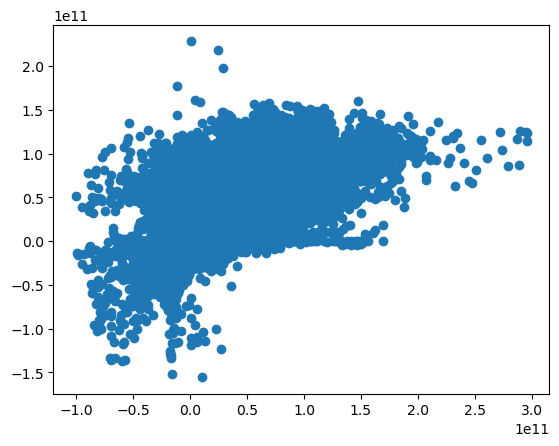

In [100]:
nt2 = np.reshape(dec_truth*area.data, [180*360, 1])
nt_idx2 = nt2 == 0
nt2[nt_idx2] = np.nan
nrecon2 = np.reshape(dec_recon*area.data, [180*360, 1])
nrecon2[nt_idx2] = np.nan
plt.scatter(nt2,nrecon2)

enoi.RMSE(nt2,nrecon2,0)
enoi.RMSE(nt2,0,0)

(enoi.RMSE(nt2,0,0) - enoi.RMSE(nt2,nrecon2,0))/enoi.RMSE(nt2,0,0)



t2 = (np.nanmean(nt2*nrecon2) - np.nanmean(nt2) * np.nanmean(nrecon2))
d2 = np.sqrt(np.nanmean(nt2**2) - np.nanmean(nt2)**2) * np.sqrt(np.nanmean(nrecon2**2) - np.nanmean(nrecon2)**2)

rho2 = t2/d2
rho2

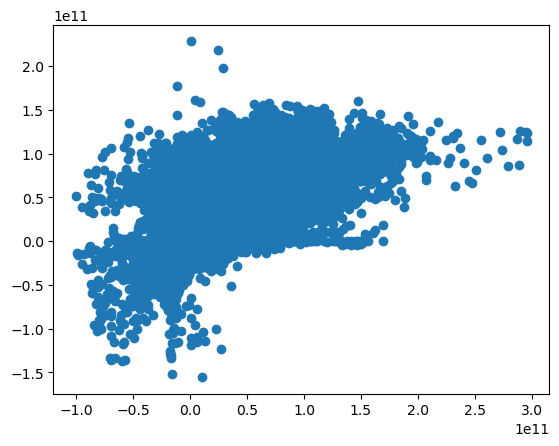

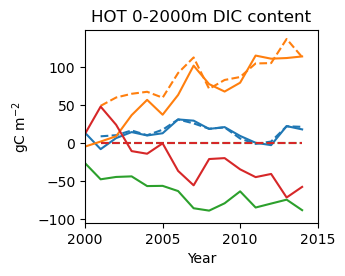

In [97]:
###############################################################################
plt.figure(figsize=(3,2.5))
plt.plot(years_full, nor_dic01_r[:,112,201]* molC2gC, label='0-100m')
plt.plot(years_argo, recon_dic_full[:,0,112,201]* molC2gC, '--', color='tab:blue')
plt.plot(years_full, (nor_dic05_r[:,112,201] - nor_dic01_r[:,112,201])* molC2gC,
             label='100-500m')
plt.plot(years_argo, (recon_dic_full[:,1,112,201]-recon_dic_full[:,0,112,201])* molC2gC, 
             '--', color='tab:orange')
plt.plot(years_full, (nor_dic10_r[:,112,201] - nor_dic05_r[:,112,201])* molC2gC,
             label='500-1000m')
plt.plot(years_argo, (recon_dic_full[:,2,112,201]-recon_dic_full[:,1,112,201])* molC2gC, 
             '--', color='tab:green')
plt.plot(years_full, (nor_dic20_r[:,112,201] - nor_dic10_r[:,112,201])* molC2gC,
             label='1000-2000m')
plt.plot(years_argo, (recon_dic_full[:,3,112,201]-recon_dic_full[:,2,112,201])* molC2gC, 
             '--', color='tab:red')
#plt.legend()
plt.xlim([2000, 2015])
#plt.ylim([0, 150])
plt.ylabel('gC m$^{-2}$')
plt.xlabel('Year')
plt.title('HOT 0-2000m DIC content')
plt.savefig("/Users/keturner/Desktop/BATS_recon_NorESM.png", dpi=200, bbox_inches="tight")

# ax_BATS = plt.subplot(2,3,2)
# plt.plot(years_full, nor_dicresid[:,121,295])
# plt.plot(years_argo, recon_dic_full[:,121,295])

# axs_HOT = plt.subplot(2,3,3)
# plt.plot(years_full, nor_dicresid[:,112,201])
# plt.plot(years_argo, recon_dic_full[:,112,201])

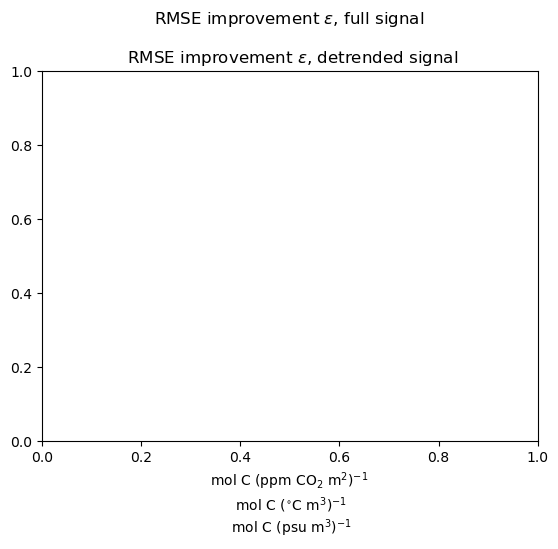

In [121]:
plt.figure()
plt.title("RMSE improvement $\epsilon$, full signal \n \n RMSE improvement $\epsilon$, detrended signal")
plt.xlabel("mol C (ppm CO$_2$ m$^2$)$^{-1}$ \n mol C ($^{\circ}$C m$^3$)$^{-1}$ \n mol C (psu m$^3$)$^{-1}$")
plt.savefig("pc_manuscript_figures/RMSE_labels.png", format="png", dpi=150, bbox_inches="tight")